In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns

In [2]:
conn = psycopg2.connect(database="postgres",
                        host="pklmart.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True

In [3]:
def pullawsdata(tablename):
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT column_name FROM information_schema.columns where table_name=\'{tablename}\';")
            cols=cursor.fetchall()
            cols = [cols[x][0] for x in range(len(cols))]
            cursor.execute(f"SELECT * FROM pklm_prd.{tablename}")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cols))
        except Exception as inst:
            print(type(inst))
            print(inst.args)
            print(inst)

In [4]:
rally=pullawsdata('rally')
rally = rally[['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']]
rally['game_id'] = [int(x[1:]) for x in rally.game_id]
rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)

In [5]:
game=pullawsdata('game')[['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']]
game['game_id'] = [int(x[1:]) for x in game.game_id]
game['match_id'] = [int(x[1:]) for x in game.match_id]
game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
game = game.sort_values(['match_id','game_id']).reset_index(drop=True)

In [6]:
#create column 'srv_win' capturing the rally winner if serving
sloc = rally.index[rally.srv_team_id == rally.w_team_id]
rally['srv_win'] = rally.srv_team_id.iloc[sloc]

In [7]:
to_games=[]
for i in game.game_id:
    igame = rally[rally.game_id==i]
    if len(igame[igame.to_team_id != 'N/A']) > 0:
        to_games.append(i)
rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(to_games).groupby(level=0).any())]

In [8]:
def generate_streak_info(df,strkcol):
    """
    Parameters
    ----------
    df: A chronologically pre-sorted homogenous dataframe
    strkcol: Column within df with 2 unique values    
    Returns
    -------
    streaks: df with a new column strk_{strkcol} with running streak sum
    """
    data = df[strkcol].to_frame()
    data['strk_init'] = data[strkcol].ne(data[strkcol].shift())
    data['strk_id'] = data.strk_init.cumsum()
    strk_field = f'strk_{strkcol}'
    data[strk_field] = data.groupby('strk_id').cumcount() + 1
    streaks = pd.concat([df, data[strk_field]], axis=1)
    streaks[strk_field] = streaks[strk_field].astype(int)
    return streaks

In [9]:
srv_win_strks=[]
for i in game.game_id:
    dfi = rally[rally.game_id==i]
    dfi = generate_streak_info(dfi,'srv_win')
    srv_win_strks.append(list(dfi.strk_srv_win))
srv_win_strks = list(np.concatenate(srv_win_strks).flat)
srv_win_strks = [int(x) for x in srv_win_strks]
rally['srv_win_strks'] = srv_win_strks
rally.srv_win_strks.iloc[rally.srv_win.isnull()] = 0

In [10]:
glist = list(rally.game_id.unique())
lencnt_pre_list = []
lencnt_post_list = []
for i in range(len(glist)):
    gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
    to_list = []
    to_game = glist[i]
    print(f'game: {to_game}')
    to_inds = list(gi.index[gi.to_team_id != 'N/A'])
    to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
    if (len(to_inds) > 0):
        for j in range(len(to_inds)):
            print(f'timeout #{j+1}')
            if j == 0:
                pre = list(range(to_inds[j]))
            else:
                pre = list(range(to_inds[j-1]+1,to_inds[j]))
            if j == len(to_inds)-1:
                post = list(range(to_inds[j]+1,len(gi)))
            else:
                post = list(range(to_inds[j]+1,to_inds[j+1]))
            toteam = to_teams[j]
            rallynbr = gi.rally_nbr.iloc[to_inds[j]]
            
            streak_pre = list(gi.iloc[pre][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks'])
            if len(streak_pre) > 0:
                print(f'streaks pre: {streak_pre}')
                cntlist_pre = list(Counter(streak_pre).values())
                print(f'overcounted lengths pre: {cntlist_pre}')
                klist_pre = list(Counter(streak_pre))
                print(f'lengths only pre: {klist_pre}')
                allcnt_pre = [[klist_pre[x],cntlist_pre[x]-cntlist_pre[x+1]] for x in range(len(cntlist_pre)-1)]
                print(f'start of length counts pre = {allcnt_pre}')
                allcnt_pre.insert(len(allcnt_pre),[klist_pre[-1],cntlist_pre[-1]])
                print(f'remaining counts pre: {allcnt_pre}')
            else:
                allcnt_pre=[(0,0)]
            print(f'final streak length counts pre: {allcnt_pre}\n\n')
            lencnt_pre_list.append(allcnt_pre)
            
            streak_post = list(gi.iloc[post][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks'])
            if len(streak_post) > 0:
                print(f'streaks post: {streak_post}')
                cntlist_post = list(Counter(streak_post).values())
                print(f'overcounted lengths post: {cntlist_post}')
                klist_post = list(Counter(streak_post))
                print(f'lengths only post: {klist_post}')
                allcnt_post = [[klist_post[x],cntlist_post[x]-cntlist_post[x+1]] for x in range(len(cntlist_post)-1)]
                print(f'start of length counts post = {allcnt_post}')
                allcnt_post.insert(len(allcnt_post),[klist_post[-1],cntlist_post[-1]])
                print(f'remaining counts post: {allcnt_post}')
            else:
                allcnt_post=[(0,0)]
            print(f'final streak length counts post: {allcnt_post}\n\n')
            lencnt_post_list.append(allcnt_post)

game: 1
timeout #1
streaks pre: [1, 2, 3, 1, 1, 1]
overcounted lengths pre: [4, 1, 1]
lengths only pre: [1, 2, 3]
start of length counts pre = [[1, 3], [2, 0]]
remaining counts pre: [[1, 3], [2, 0], [3, 1]]
final streak length counts pre: [[1, 3], [2, 0], [3, 1]]


streaks post: [1]
overcounted lengths post: [1]
lengths only post: [1]
start of length counts post = []
remaining counts post: [[1, 1]]
final streak length counts post: [[1, 1]]


timeout #2
streaks pre: [1, 1, 1, 1]
overcounted lengths pre: [4]
lengths only pre: [1]
start of length counts pre = []
remaining counts pre: [[1, 4]]
final streak length counts pre: [[1, 4]]


streaks post: [1, 2, 1, 1]
overcounted lengths post: [3, 1]
lengths only post: [1, 2]
start of length counts post = [[1, 2]]
remaining counts post: [[1, 2], [2, 1]]
final streak length counts post: [[1, 2], [2, 1]]


timeout #3
streaks pre: [1, 2, 1, 1]
overcounted lengths pre: [3, 1]
lengths only pre: [1, 2]
start of length counts pre = [[1, 2]]
remaining c

/var/folders/6j/jm46__255sd7_8mn_w2wrk_00000gq/T/ipykernel_5756/102063283.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  streak_pre = list(gi.iloc[pre][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks'])
/var/folders/6j/jm46__255sd7_8mn_w2wrk_00000gq/T/ipykernel_5756/102063283.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  streak_post = list(gi.iloc[post][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks'])
/var/folders/6j/jm46__255sd7_8mn_w2wrk_00000gq/T/ipykernel_5756/102063283.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  streak_pre = list(gi.iloc[pre][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks'])
/var/folders/6j/jm46__255sd7_8mn_w2wrk_00000gq/T/ipykernel_5756/102063283.py:42: UserWarning: Boolean Series key will be reindexed to 

game: 14
timeout #1
streaks pre: [1, 2, 3, 4, 5]
overcounted lengths pre: [1, 1, 1, 1, 1]
lengths only pre: [1, 2, 3, 4, 5]
start of length counts pre = [[1, 0], [2, 0], [3, 0], [4, 0]]
remaining counts pre: [[1, 0], [2, 0], [3, 0], [4, 0], [5, 1]]
final streak length counts pre: [[1, 0], [2, 0], [3, 0], [4, 0], [5, 1]]


streaks post: [1, 2, 1, 1, 2, 1]
overcounted lengths post: [4, 2]
lengths only post: [1, 2]
start of length counts post = [[1, 2]]
remaining counts post: [[1, 2], [2, 2]]
final streak length counts post: [[1, 2], [2, 2]]


game: 15
timeout #1
streaks pre: [1, 2, 1, 2, 3]
overcounted lengths pre: [2, 2, 1]
lengths only pre: [1, 2, 3]
start of length counts pre = [[1, 0], [2, 1]]
remaining counts pre: [[1, 0], [2, 1], [3, 1]]
final streak length counts pre: [[1, 0], [2, 1], [3, 1]]


streaks post: [1, 2, 1]
overcounted lengths post: [2, 1]
lengths only post: [1, 2]
start of length counts post = [[1, 1]]
remaining counts post: [[1, 1], [2, 1]]
final streak length counts 

/var/folders/6j/jm46__255sd7_8mn_w2wrk_00000gq/T/ipykernel_5756/102063283.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  streak_pre = list(gi.iloc[pre][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks'])
/var/folders/6j/jm46__255sd7_8mn_w2wrk_00000gq/T/ipykernel_5756/102063283.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  streak_post = list(gi.iloc[post][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks'])
/var/folders/6j/jm46__255sd7_8mn_w2wrk_00000gq/T/ipykernel_5756/102063283.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  streak_pre = list(gi.iloc[pre][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks'])
/var/folders/6j/jm46__255sd7_8mn_w2wrk_00000gq/T/ipykernel_5756/102063283.py:42: UserWarning: Boolean Series key will be reindexed to 

In [11]:
lencnt_pre_list = sum(lencnt_pre_list,[])
full_counts_pre="".join([x[1]*str(x[0]) for x in lencnt_pre_list])
cum_counts_pre = Counter(full_counts_pre)
cum_counts_pre_keys = [int(x) for x in list(cum_counts_pre.keys())]
cum_counts_pre_values = cum_counts_pre.values()
dist_pre = sorted([(x,y) for x,y in zip(cum_counts_pre_keys,cum_counts_pre_values)])
num_pre = sum([x[1] for x in dist_pre])
pcts_pre = [(x[0],int(round(100*(x[1]/num_pre),0))) for x in dist_pre]
print(pcts_pre)

[(1, 69), (2, 19), (3, 8), (4, 3), (5, 1)]


In [18]:
df_pcts_pre = pd.DataFrame(pcts_pre,columns=['streak','pre_pct'])

In [13]:
lencnt_post_list = sum(lencnt_post_list,[])
full_counts_post="".join([x[1]*str(x[0]) for x in lencnt_post_list])
cum_counts_post = Counter(full_counts_post)
cum_counts_post_keys = [int(x) for x in list(cum_counts_post.keys())]
cum_counts_post_values = cum_counts_post.values()
dist_post = sorted([(x,y) for x,y in zip(cum_counts_post_keys,cum_counts_post_values)])
num_post = sum([x[1] for x in dist_post])
pcts_post = [(x[0],int(round(100*(x[1]/num_post),0))) for x in dist_post]
print(pcts_post)

[(1, 76), (2, 16), (3, 6), (4, 1), (5, 1)]


In [19]:
df_pcts_post = pd.DataFrame(pcts_post,columns=['streak','post_pct'])

In [31]:
df_streak_prepost = pd.concat([df_pcts_pre,df_pcts_post[['post_pct']]],axis=1)
df_streak_prepost

,streak,pre_pct,post_pct
0,1,69,76
1,2,19,16
2,3,8,6
3,4,3,1
4,5,1,1


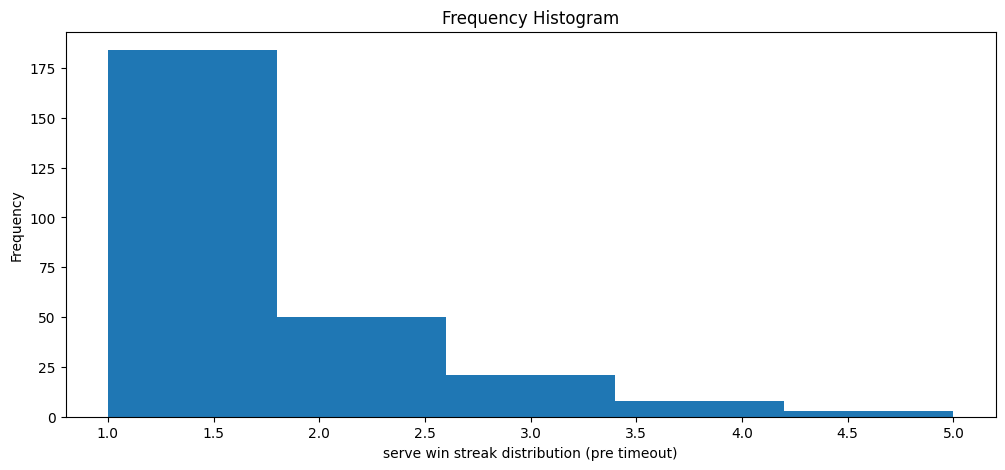

In [28]:
%matplotlib inline
dpre = [int(x) for x in (full_counts_pre)]
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(dpre, bins=5)
plt.gca().set(title='Frequency Histogram', xlabel = 'serve win streak distribution (pre timeout)', ylabel='Frequency');

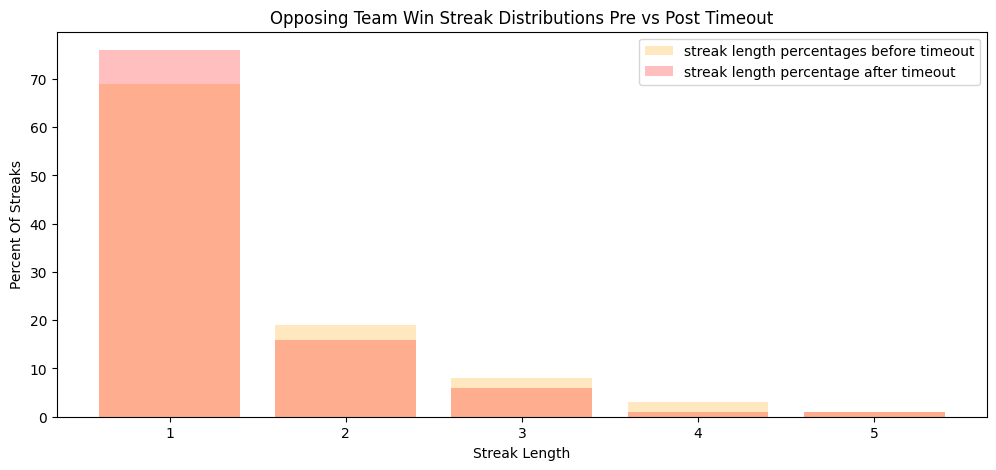

In [58]:
streak_lengths = df_streak_prepost.streak
pre_timeout = df_streak_prepost.pre_pct
post_timeout = df_streak_prepost.post_pct

# Plotting both the curves simultaneously
plt.(streak_lengths, pre_timeout, color='orange', alpha = .25,label='streak length percentages before timeout')
plt.bar(streak_lengths, post_timeout, color='red', alpha = .25,label='streak length percentage after timeout')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Streak Length")
plt.ylabel("Percent Of Streaks")
plt.title("Opposing Team Win Streak Distributions Pre vs Post Timeout")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

<AxesSubplot: title={'center': 'Timeout Impact On Opponent Momentum'}, xlabel='Opponent Winning As Server Streak Length', ylabel='Percentage'>

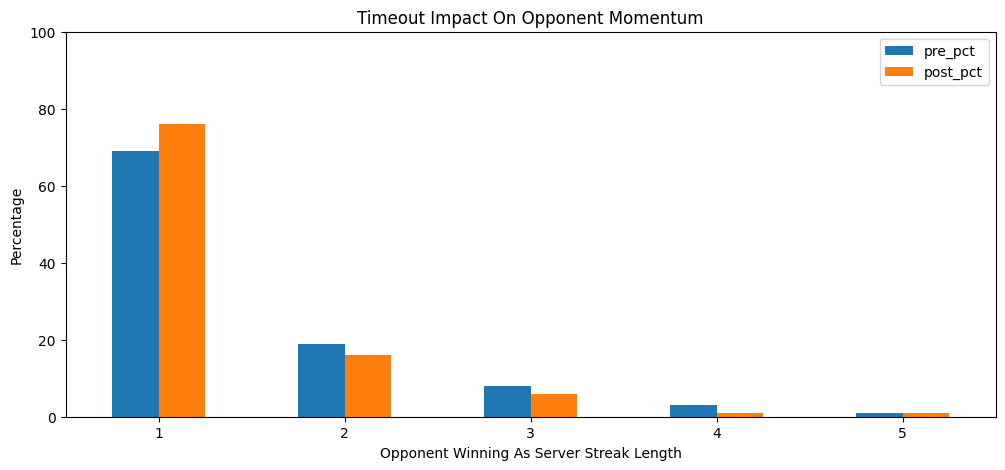

In [72]:
df_streak_prepost.plot(x="streak",y=["pre_pct","post_pct"],kind="bar",ylim=(0,100),rot=0,title="Timeout Impact On Opponent Momentum", xlabel="Opponent Winning As Server Streak Length",ylabel="Percentage")